,x,z,y
0,0.000000,0.204082,0.000000
1,0.408163,0.612245,4.166597
2,0.816327,1.020408,3.666389
3,1.224490,1.428571,5.499375
4,1.632653,1.836735,2.665556


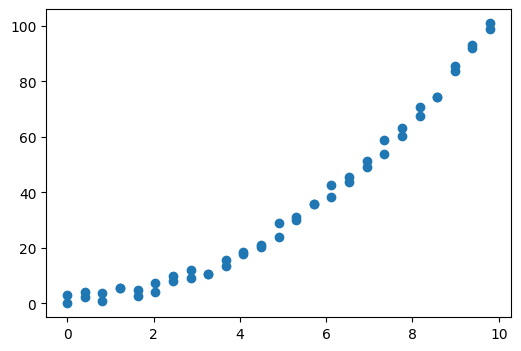

In [1]:
import pandas as pd
import numpy as np
from random import randint, choice, uniform
import graphviz

def func(x):
    return x**2 + randint(0, 5)
vfunc = np.vectorize(func)

X = np.array([np.linspace(0, 10), np.linspace(0, 10)]).reshape(-1, 2)
y = vfunc(X[:, 0])

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(X[:, 0], y)

data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
data.columns = ["x", "z", "y"]
data.to_csv("data.csv", index=False)
data.head()

# Expression Trees

In [2]:
class ExpressionTree():
    """Tree used in the symbolic regression algorithm"""
    
    class Node:
        __slots__ = "_element", "_parent", "_left", "_right", "_element_type", "weight", "island"
        def __init__(self, element, parent=None, left=None, right=None, element_type=None):
            self._element = element
            self._parent = parent
            self._left = left
            self._right = right
            
            self._element_type = element_type
        
        def element(self):
            return self._element
    
    
    class Position():
        def __init__(self, container, node):
            self._container = container
            self.Node = node
            
        def __eq__(self, other):
            return type(other) is type(self) and other.Node is self.Node
        
        def __neq__(self, other):
            raise not (self == other)
            
        def element_type(self):
            return self.Node._element_type
            
        def element(self):
            return self.Node._element
        

    def __init__(self, fitness_score = None, island=None):
        self._root = None
        self._size = 0
        self.fitness_score = fitness_score
        self.island = island
        
    def _validate(self, p):
        """Return associated node, if position p is valid"""
        if not isinstance(p, self.Position):
            raise TypeError("p must be proper Position type")
            
        if p._container is not self:
            raise ValueError("p does not belong to this container")
            
        if p.Node._parent is p.Node:   # Convention for deprecated nodes
            raise ValueError("p is no longer valod")
            
        return p.Node
    
    def _make_position(self, node):
        return self.Position(self, node) if node is not None else None
    
    def __len__(self):
        return self._size
    
    def root(self):
        return self._make_position(self._root)
    
    def parent(self, p):
        node = self._validate(p)
        return self._make_position(node._parent)
    
    def left(self, p):
        node = self._validate(p)
        return self._make_position(node._left)
    
    def right(self, p):
        node = self._validate(p)
        return self._make_position(node._right)
    
    def sibling(self, p):
        parent = self.parent(p)
        
        if parent is None:  # if p is root
            return None
        
        if p == self.left(parent):
            return self.right(parent)
        else:
            return self.left(parent)
        
    def children(self, p):
        if self.left(p) is not None:
            yield self.left(p)
        if self.right(p) is not None:
            yield self.right(p)
            
    def num_children(self, p):
        """Number of direct children of Position p"""
        node = self._validate(p)
        count = 0
        
        if node._left is not None:   #left child exists
            count += 1
        if node._right is not None:  #right child exists
            count += 1
        return count
    
    def is_root(self, p):
        return self.root() == p
    
    def is_leaf(self, p):
        return self.num_children(p) == 0
    
    def is_empty(self):
        return len(self) == 0    
    
    def add_root(self, e, e_type=None):
        """Place element e at the root of an empty tree and return new Position
        
        Raise ValueError is tree nonempty"""
        
        if self._root is not None: raise ValueError("Root exisits")
        self._size = 1
        self._root = self.Node(e, element_type=e_type)
        return self._make_position(self._root)
    
    def add_left(self, p, e, e_type=None):
        """Create a new left child for Position p, storing element e
        
        Return the Position of new node
        Raise ValueError is Position p is invalid or p alredy has a left child"""
        
        node = self._validate(p)
        if node._left is not None: raise ValueError("Left child exists")
        self._size += 1
        node._left = self.Node(e, node, element_type = e_type)
        return self._make_position(node._left)
        
    def add_right(self, p, e, e_type=None):
        """Create a new right child for Position p, storing element e
        
        Return the Position of new node
        Raise ValueError is Position p is invalid or p alredy has a right child"""
        
        node = self._validate(p)
        if node._right is not None: raise ValueError("Right child exists")
        self._size += 1
        node._right = self.Node(e, node, element_type = e_type)
        return self._make_position(node._right)
    
    def delete(self, p):
        """Delete the node at Position p and replace it with its child, if any.
        
        Return the element that had been stored at Position p.
        Raise ValueError if Position p is invalid or p has two children"""
        
        node = self._validate(p)
        if self.num_children(p) == 2: raise ValueError("p has two children")
        child = node._left if node._left else node._right    #might be None
        
        if child is not None:
            child._parent = node._parent
        
        if node is self._root:   # if node = root child becomes new root
            self._root = child
        else:    # if not must update grandparent
            parent = node._parent
            if node is parent._left:
                parent._left = child
            else:
                parent._right = child
            self._size -= 1
            node._parent = node   #convention for deprecated node
            return node._element
        
    def _attach(self, p, t1=None, t2=None):
        """Attach trees t1 and t2 as left and right subtrees of external p
        
        Raise ValueError if p is not a leaf
        Raise TypeError is all three tree types are not the same"""
        
        node = self._validate(p)
        if not self.is_leaf(p): raise ValueError("Position must be leaf")
        
        # check if all 3 are trees of the same type
        if not type(self) is type(t1) is type(t2):
            raise TypeError("Tree types must match")    
        self._size += len(t1) + len(t2)   # we use len becouse ._size is private and t1 and t2 are external
        
        # Attach t1 to the left
        if not t1.is_empty():
            t1._root._parent = node
            node._left = t1._root
            t1._root = None   # Set t1 instance to empty
            t1._size = 0
        # Attach t2 to the right
        if not t2.is_empty():
            t2._root._parent = node
            node._right = t2._root
            t2._root = None
            t2._size = 0
        
    
    def replace(self, p, e, e_type=None):
        """Replace the element at position p with e, and return old element"""
        
        node = self._validate(p)
        old = node._element
        node._element = e
        node._element_type = e_type
        return old
    
    def is_left(self, p):
        "Return if the position is a left child of its parent"
        return p == self.left(self.parent(p))
    
    def attach_subtree(self, p, subtree):
        """Removes the informod position p and attaches the input subtree in its place. 
        p must be a leaf"""
        if not self.is_leaf(p): raise ValueError("Position must be leaf")

        # check if all 3 are trees of the same type
        if not type(self) is type(subtree):
            raise TypeError("Tree types must match")    
        self._size += len(subtree) - 1 # -1 since we'll remove the leaf 
        
        if subtree.is_empty():
            raise ValueError("Tree can't be empty")
        
        parent = self.parent(p)
        node = self._validate(parent)
        # Attach to the left
        if self.is_left(p):
            self.delete(p)
            subtree._root._parent = node
            node._left = subtree._root
            subtree._root = None   
            subtree._size = 0
        # Attach to the right
        else:
            self.delete(p)
            subtree._root._parent = node
            node._right = subtree._root
            subtree._root = None
            subtree._size = 0
            
    def visualize_tree(self):
        """Not efficient AT ALL, but since this is only a visualization method that
        will be used on a single tree by user's request, and not as a part of the method itself,
        it shouldn't matter.
        
        Here we use the element_type attribute as an unique id for each node in the tree."""
        
        id_tree = self.copy_tree(self.root())
        
        for c, p in enumerate(id_tree.preorder()):
            p.Node._element_type = c
    
        dot = graphviz.Digraph()
        dot.node(str(id_tree.root().Node._element_type), str(id_tree.root().element()))
        
        for p in id_tree.preorder():
            if id_tree.left(p):
                node_content = str(id_tree.left(p).element())
                element_type = str(id_tree.left(p).Node._element_type)
                parent_element_type = str(p.Node._element_type)
                dot.node(element_type, node_content)
                dot.edge(parent_element_type, element_type)
            if id_tree.right(p):
                node_content = str(id_tree.right(p).element())
                element_type = str(id_tree.right(p).Node._element_type)
                parent_element_type = str(p.Node._element_type)
                dot.node(element_type, node_content)
                dot.edge(parent_element_type, element_type)
        return dot
            
    
    def copy_tree(self, root):
        """!!!!!!! Não muito eficiente pois precisa de um loop para definir os pais de cada nó"""
        new_tree = ExpressionTree()
        
        def auxilary_function(root):
            """Recursive part of copying the tree"""
            if root == None:
                return None
            
            new_node = new_tree.Node(root._element, element_type=root._element_type)
            parent_node = new_node
            new_node._left = auxilary_function(root._left)
            new_node._right = auxilary_function(root._right)
            
            return new_node
        
        def set_parents(new_tree):
            """Correctly assigns the parent to each node on the tree"""
            new_tree.root().Node._parent = None
            for p in new_tree.preorder():

                if new_tree.left(p):
                    p.Node._left._parent = p.Node
                if new_tree.right(p):
                    p.Node._right._parent = p.Node
        
        new_tree._root = auxilary_function(root.Node)
        new_tree._size = self._size
        set_parents(new_tree)
        
        return new_tree

     # ------------------------- Preorder -------------------------
    
    def preorder(self):
        if not self.is_empty():
             for p in self._subtree_preorder(self.root()):
                    yield p
    
    def _subtree_preorder(self, p):
        yield p
        for c in self.children(p):
            for other in self._subtree_preorder(c):
                yield other
                
    # ------------------------- Postorder -------------------------
    
    def postorder(self):
        if not self.is_empty():
            for p in self._subtree_postorder(self.root()):
                yield p
    
    def _subtree_postorder(self, p):
        for c in self.children(p):
            for other in self._subtree_postorder(c):
                yield other
        yield p
        
    # ------------------------- Inorder -------------------------
    
    def inorder(self):
        if not self.is_empty():
            for p in self._subtree_inorder(self.root()):
                yield p
    
    def _subtree_inorder(self, p):
        if self.left(p) is not None:
            for other in self._subtree_inorder(self.left(p)):
                yield other
        yield p
        if self.right(p) is not None:
            for other in self._subtree_inorder(self.right(p)):
                yield other
                
    def positions(self):
        return self.preorder()
    
    def __iter__(self):
        for p in self.positions():
            yield p.element()
        

# Brute Force Elitist GP Symbolic Regression

In [3]:
class SymbolicRegression():
    """X: N vector of independent M-featured training points
       Y: N vector f dependent variables
       G: Number of generations to train
       Output: Champion s-expression individual
       Parameters: maxPopSize MasIslandCount
       
       Summary: Brute force elitist GP searches for a champion s-expression by randomly growing and scoring a
                large number of candidate s-expressions, then iteratively creating and scoring new candidate
                s-expressions via mutation and crossover. After each iteration, the population of candidate
                s-expressions is truncated to those with the best fitness score. After the final iteration, the
                champion is the s-expression with the best fitness score"""
    
    __slots__ = ("X", "y", "G", "_feature_names", "label_name", "max_population_size", "max_expression_size",
                 "_operators", "_functions", "_options", "_operators_func", "_functions_func", "_features", 
                "max_island_count", "max_island_size", "_weights")
    def __init__(self, G, feature_names=None, label_name="y", max_population_size=5000, max_expression_size = 5, max_island_count=500, 
                max_island_size = False):
        """- feature_names: A list containing the names of every feature in X"""
        
        self.y = None
        self.G = G
        
        self.max_population_size = max_population_size
        self.max_expression_size = max_expression_size
        self.max_island_count = max_island_count
        if not max_island_size: 
            self.max_island_size = int(max_population_size / max_island_count)

        
        """ I've chosen to let _operatos and _functions here to reduce call 
            of list() and .keys() from _operators_func and _functions_func 
           having efficiency in mind """
        
        self._operators = ["+", "-", "*", "/"] # "/"
        self._functions = ["abs", "square", "cube", "quart", "cos", "sin",
                          "tan", "tanh", "exp", "sqrt", "log"] # "max", "min"
            
        self._options = {"operator": lambda: choice(self._operators), "function": lambda: choice(self._functions),
                        "feature": lambda: choice(self._feature_names), "constant": lambda: round(uniform(0,10), 3)}
        
        # Its better if this is here, instead of having a copy of everything in each tree
        self._operators_func = {"+": lambda a,b: np.add(a,b), "-": lambda a,b: np.subtract(a,b),
                                "*": lambda a,b: np.multiply(a, b), "/": lambda a,b: np.divide(a,b)}
        self._functions_func = {"abs": lambda a: np.abs(a), "exp": lambda a: np.exp(a), "square": lambda a: a**2,
                               "cube": lambda a: a**3, "quart": lambda a: a**4, "cos": lambda a: np.cos(a),
                               "sin": lambda a: np.sin(a), "tan": lambda a: np.tan(a), "tanh": lambda a: np.tanh(a),
                               "sqrt": lambda a: np.sqrt(a), "log": lambda a: np.log(a)}
    
        self._weights = {
            "+": 1, "-": 1, "*": 2, "/": 2,
            "sqrt": 3, "square": 2, "cube": 2, "quart": 2,
            "log": 4, "exp": 4, "cos": 5, "sin": 5, 
            "tan": 6, "tanh": 6, "abs": 1
        }
        
    def fit(self, X, y, feature_names=None, label_name="y"):
        if type(X) != np.ndarray:
            raise TypeError("X must be an array")
    
        self.y = y
        self.label_name = label_name
        
        if feature_names == None:
            # This is necessary for a one dimensional array
            if X.shape[0] == 1:
                self._feature_names = ["x0"]
            else:
                self._feature_names = ["x" + f"{i}" for i in range(0, X.shape[1])]
        else:
            self._feature_names = feature_names
            
        self.label_name = label_name
        
        # self._features is used in place of X, to express the data points
        self._features = {}
        for c, name in enumerate(self._feature_names):
            self._features[name] = X[:, c]
    
    
    def _generate_placeholder_tree(self, size):
        """Generates a placeholder tree that later will be randomly filled to create a random expression, respecting
        the operations."""
        tree = ExpressionTree()
        
        p = tree.add_root(0)
        
        def auxilary_generator(size, p):
            if size <= 0:
                return None            

            left_size = randint(0, size-1) 
            right_size = size - left_size - 1

            # Sometimes skips the left node - thus making possible to generate functions
            if randint(0,1): 
                left_p = tree.add_left(p, 0)
                auxilary_generator(left_size, left_p)
                
            right_p = tree.add_right(p, 0)
            auxilary_generator(right_size, right_p)
        
        auxilary_generator(size, p)
        
        return tree
    
    def generate_expr(self, size=None):
        """Creates and returns a random expression tree of a given size."""
        if size == None:
            size = self.max_expression_size
        tree = self._generate_placeholder_tree(size)

        
        for p in tree.inorder():
            
            if tree.is_leaf(p):
                if randint(0,1):
                    tree.replace(p, choice(self._feature_names), "feature")
                else:
                    tree.replace(p, round(uniform(0,1), 3), "constant")
            elif tree.num_children(p) > 1:
                tree.replace(p, choice(self._operators), "operator")
            elif tree.num_children(p) == 1:
                tree.replace(p, choice(self._functions), "function")
                
        return tree

    def mutateSExp(self, me):
        """mutateSExp randomly alters an input s-expression by replacing a randomly selected sub expression 
        with a new randomly grown sub expression"""
        
        copied = me.copy_tree(me.root())
        L = len(me)
        n_steps = randint(0, L)
        
        for c, p in enumerate(copied.inorder()):
            if c == n_steps:
                
                if not copied.is_leaf(p):
                    copied.replace(p, self._options[p.element_type()](), p.element_type())
                    
                else:
                    random_number = randint(0,2)                    
                    if random_number == 0:
                        copied.replace(p, self._options[p.element_type()](), p.element_type())

                    elif random_number == 1:
                        size = randint(1, 2)
                        subtree = self.generate_expr(size)
                        
                        copied.attach_subtree(p,subtree)
                    
                    elif random_number == 2:
                        parent = copied.parent(p)
                        e_type = parent.element_type()
                        copied.delete(p)
                        
                        if e_type == "fuction": # if the parent was function becomes feature or constant
                            if randint(0,1):
                                copied.replace(parent, choice(self._feature_names), "feature")
                            else:
                                copied.replace(parent, uniform(0,1), "constant")
                        else: # can only be operator
                            copied.replace(parent, choice(self._functions), "function")
        
                break        
        return copied
    
    
    def crossoverSExp(self, mom, dad):
        """crossoverSExp randomly alters a mom input s-expression by replacing a randomly selected sub expression
        in mom with a randomly selected sub expression from dad."""
        
        """!!!!!!!!!!Just like in mutation, must implent types of subtrees that are possible to get from father, and for each type
        do a specific operation in mom"""
        
        dad = dad.copy_tree(dad.root())
        mom = mom.copy_tree(mom.root())
        Ld = len(dad)
        Lm = len(mom)
        n = randint(0, Ld-1)
        m = randint(0, Lm-1)
        
        # getting father sub expression
        for c, p in enumerate(dad.inorder()):
            if c == n:
                sub_expression = dad.copy_tree(p)
                break
        
        for c, p in enumerate(mom.inorder()):
            if (c >= m) and (mom.is_leaf(p)):
                mom.attach_subtree(p, sub_expression)
                break
        
        return mom
    
    def optimizeConstants(self, me):
        """Optimize any embedded constants in me"""
        return self.mutateSExp(me)
        
    def insertLambda(self, population, lamb):
        """Inserts the specified lambda into the specified population unordered
        population: Numpy array
        lambda: Expression tree
        """
        if len(population) <= 0:
            population = np.array([])
        
        population = np.append(population, lamb)
        return population
    
    def evaluate_tree(self, tree):     
        saida = np.array([])
        
        
        previous_left_value = False
            
        # Calcula o valor da árvore para um x
        for p in tree.postorder():
            num_children = tree.num_children(p)
            if num_children == 2: # é operador
                left_value = self._operators_func[p.element()](left_value, right_value)
                previous_left_value = True

            elif num_children == 1: # é função
                if previous_left_value:
                    left_value = self._functions_func[p.element()](left_value)
                else:
                    right_value = self._functions_func[p.element()](right_value)

            else: # é constante ou feature
                if type(p.element()) != str: #é constante
                    element = p.element()
                else: # é feature
                    element = self._features[p.element()]

                if previous_left_value:
                    right_value = element
                    previous_left_value = False
                else:
                    left_value = element
                    previous_left_value = True
        saida = np.append(saida, left_value)
            
        return saida
    
    def fitness_score(self, tree, custom_func=None):
        if not custom_func: # mean squared error
            def custom_func(y, y_pred):
                return np.mean((y - y_pred)**2)
            
        predicted = self.evaluate_tree(tree)
        return custom_func(self.y, predicted)
    
    def sort_tree_array(self, array):
        def get_fitness(tree):
            return tree.fitness_score
        
        vectorized_function = np.vectorize(get_fitness)
        
        fitness_array = vectorized_function(array)
        fitness_array = np.argsort(fitness_array)
        return array[fitness_array]
    
    # ------------------ Constant Optimization --------------
    
    def _convert_to_AEG(self, lamb):
        return lamb
    
    
        
    # ------------------ Population pruning --------------
    
    def _weightedComlexity(self, tree: ExpressionTree):
        """Returns a complexity score where each function operator has a different weigh"""
        
        complexity = 0

        for element in tree.preorder():
            n_child = tree.num_children(element)
            if n_child >= 1:
                complexity += (n_child+1) * self._weights[element.element()]
                # add one because the element itself counts as one element of the block
                
        return complexity
    
    
    def populationPruning(self, in_population, out_population, islands):
        """Copies the input into the output population
        Adds random individuals to the output population
        Sorts the output population in asceding order of fitness score
        Computes the weighted complpexity score of each individuals and
        assings each individual to a complexity island
        Eliminates all non-dominant individuals in each compplexity island
        Truncates the output population to the maximum population size
        Always organizes the population into multiple separate islands by complexity"""
        
        out_population = np.array([])
        
        #initialize with random individuals
        if (len(in_population) <= 0):
            K = int(5*self.max_population_size)
            
            # Initialize population
            for k in range(K):
                lamb = self.generate_expr()
                lamb = self._convert_to_AEG(lamb)
                lamb.fitness_score = self.fitness_score(lamb)
                lamb.weight = None
                out_population = self.insertLambda(out_population, lamb)
        # Copy and add a few more random individuals
        else:    
            out_population = np.copy(in_population)
            K = int(self.max_population_size/10)
            
            # Initialize new random population
            for k in range(K):
                lamb = self.generate_expr()
                lamb = self._convert_to_AEG(lamb)
                lamb.fitness_score = self.fitness_score(lamb)
                lamb.weight = None
                out_population = self.insertLambda(out_population, lamb)
        
        # Sorting out_population by fitness score
        out_population = self.sort_tree_array(out_population)
        out_population = out_population[0:self.max_population_size]
            
        # Compute weighted complexity range
        N = len(out_population)
        high = low = self._weightedComlexity(out_population[0])
        
        for n in range(N):
            lamb = out_population[n]
            if (lamb.weight == None):
                lamb.weight = self._weightedComlexity(lamb)
                weight = lamb.weight
                
                if (weight < low):
                    low = weight
                if (weight > high):
                    high = weight
        
        weight_range = high-low
        island_counts = np.zeros(self.max_island_count)
        in_population = np.array([])
        islands = np.zeros(self.max_island_count, dtype="object")
        
        # Always return island structure with one island for each complexity partition
        # prune all non-dominant individuals in each pareto front complexity island
        
        # Inserting all elements in their respective islands
        for n in range(N):
            lamb = out_population[n]
            weight = lamb.weight
            island = int(self.max_island_count * ((weight-low) / weight_range)) 
            
            # The tree is too complex, then it goes to the last place
            if island >= self.max_island_count:
                island = self.max_island_count-1
            lamb.island = island
            
            
            island_counts[island] = island_counts[island] + 1     # Increasing the count of element inside the island
            if (island_counts[island] <= self.max_island_size):
                in_population = np.append(in_population,lamb)
                if (type(islands[island]) is int): islands[island] = []
                islands[island] = np.append(islands[island],lamb)
        
        # This is the same as the first element of the out_population
        # Which was ordered is ascending order of fitness score
        champ = in_population[0]
        return champ, islands, in_population  
    
    
    def predict(self):
        max_island_count = 1
        in_population = np.array([])
        out_population = np.array([])
        islands = np.array([])
        
        if(self.G <= 0):
            champ, islands, in_population = self.populationPruning(in_population, out_population, islands)
        P = len(in_population)
        
        for g in range(0, self.G): # Main evolution loop
            P = len(in_population)
            
            # Everyone gets mutated and crossed over
            for p in range(0, P):
                lamb = self.optimizeConstants(in_population[p])
                out_population = self.insertLambda(out_population, lamb)
                lamb = self.mutateSExp(in_population[p])
                out_population = self.insertLambda(out_population, lamb)
                dad = in_population[p] # every one gets crossed over (gets to be a dad)
                
                # Cross over partner must be from the same island
                K = dad.island
                i = randint(0, len(islands[K])-1)
                mom = islands[K][i]   # Getting a random tree from the same island as dad
                lamb = self.crossoverSExp(dad, mom)
                out_population = self.insertLambda(out_population, lamb)
            
            champ, islands, in_population = self.populationPruning(in_population, out_population, islands)
        return champ

In [13]:
np.c_[X[:, 0]]

array([[0.        ],
       [0.40816327],
       [0.81632653],
       [1.2244898 ],
       [1.63265306],
       [2.04081633],
       [2.44897959],
       [2.85714286],
       [3.26530612],
       [3.67346939],
       [4.08163265],
       [4.48979592],
       [4.89795918],
       [5.30612245],
       [5.71428571],
       [6.12244898],
       [6.53061224],
       [6.93877551],
       [7.34693878],
       [7.75510204],
       [8.16326531],
       [8.57142857],
       [8.97959184],
       [9.3877551 ],
       [9.79591837],
       [0.        ],
       [0.40816327],
       [0.81632653],
       [1.2244898 ],
       [1.63265306],
       [2.04081633],
       [2.44897959],
       [2.85714286],
       [3.26530612],
       [3.67346939],
       [4.08163265],
       [4.48979592],
       [4.89795918],
       [5.30612245],
       [5.71428571],
       [6.12244898],
       [6.53061224],
       [6.93877551],
       [7.34693878],
       [7.75510204],
       [8.16326531],
       [8.57142857],
       [8.979

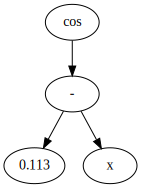

13

In [15]:
SR = SymbolicRegression(10, max_expression_size=3)
SR.fit(np.c_[X[:, 0]], y, feature_names = ["x"])
tree = SR.generate_expr(2)

display(tree.visualize_tree())

SR._weightedComlexity(tree)

In [16]:
output_expr = SR.predict()

C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:48: RuntimeWarning: invalid value encountered in sqrt
  "sqrt": lambda a: np.sqrt(a), "log": lambda a: np.log(a)}
C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:44: RuntimeWarning: invalid value encountered in divide
  "*": lambda a,b: np.multiply(a, b), "/": lambda a,b: np.divide(a,b)}
C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:48: RuntimeWarning: divide by zero encountered in log
  "sqrt": lambda a: np.sqrt(a), "log": lambda a: np.log(a)}
C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:44: RuntimeWarning: divide by zero encountered in divide
  "*": lambda a,b: np.multiply(a, b), "/": lambda a,b: np.divide(a,b)}
C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:44: RuntimeWarning: invalid value encountered in multiply
  "*": lambda a,b: np.multiply(a, b), "/": lambda a,b: np.divide(a,b)}
C:\Users\lreis\AppData\Local\Temp\ipykernel_10780\994496868.py:46: Runtim

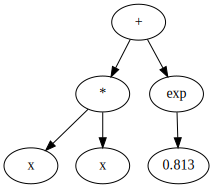

In [17]:
output_expr.visualize_tree()

In [23]:
def func(x):
    return x**2 + np.exp(0.813)

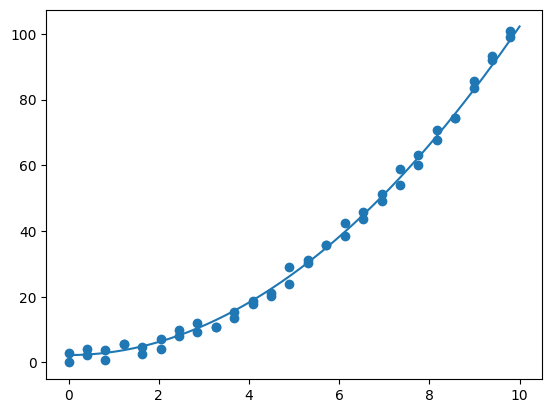

In [24]:
X_plot = np.linspace(0, 10)
y_plot = func(X_plot)

plt.scatter(X[:, 0], y)
plt.plot(X_plot, y_plot)